# 2. 머신러닝 프로젝트 처음부터 끝까지
부동산 회사에 고용된 데이터 과학자라고 가정하고 프로젝트를 처음부터 끝까지 진행.
1. 큰 그림을 본다.
2. 데이터를 구한다.
3. 디이터로부터 통찰을 얻기 위해 탐색하고 시각화한다.
4. 머신러닝 알고리즘을 위해 데이터를 준비한다.
5. 모델을 선택하고 훈련시킨다.
6. 모델을 상세하게 조정한다.
7. 솔루션을 제시한다.
8. 시스템을 론칭하고 모니터링하고 유지보수한다.

## 2.1 실제 데이터로 작업하기
공개되어 있는 데이터셋에서 실제 데이터로 실험해보는 것이 좋다.
이 장에서는 StatLib 저장소의 캘리포니아 주택 가격 데이터셋을 사용한다.

## 2.2 큰 그림 보기
가장 먼저 할 일은 캘리포니아 인구조사 데이터를 사용해 캘리포니아의 주택 가격 모델을 만드는 것이다.
모델을 학습시켜서 다른 측정 데이터가 주어졌을 때 구역의 중간 주택 가격을 예측해야 한다.
    
### 2.2.1 문제 정의

레이블된 훈련 샘플이 있다. -> 지도학습  
값을 예측 -> 회귀 문제  
예측에 사용할 특성이 여러 개 -> 다중 회귀  
각 구역마다 하나의 값을 예측 -> 단변량 회귀 / 구역마다 여러 값을 예측하면 다변량 회귀  
데이터에 연속적인 흐름이 없어 빠른 변화에 적응하지 않아도 됨, 데이터가 메모리에 들어갈 만큼 작음 -> 배치학습  


### 2.2.2 성능 측정 지표 선택
회귀 문제의 전형적인 성능 지표 : 평균 제곱근 오차(root mean square error)/(RMSE) 
오차가 커질수록 값이 더 커짐.  
    
식 : $RMSE(X,h) = \sqrt{1/m\sum_{i=1}^m (h(x^{(i)})-y^{(i)})^2}$
* 표기법
    m : 데이터셋의 샘플 수<br>
    $x{(i)}$ : 데이터 셋의 i번째 샘플의 전체 특성 값의 벡터<br>
    $y{(i)}$ : 해당 레이블  
    X : 데이터셋에 있는 모든 샘플의 모든 특성값을 포함하는 행렬  
    h : 시스템의 예측 함수. 가설(hypothesis)이라고도 한다.  
    샘플에 대한 예측값은 $h(x^{(i)})$이며 예측오차는 $(h(x^{(i)})-y^{(i)})^2$ 이다.
    
경우에 따라 다른 성능 지표가 사용된다.  
    
ex) 이상치가 많을 때 : 평균 절대 오차(mean absolute error)/(MAE)  
식 : $MAE(X,h) = 1/m\sum_{i=1}^m |h(x^{(i)})-y^{(i)}|$  
RMSE, MAE 모두 예측값의 벡터와 타깃값의 벡터 사이의 거리를 재는 방법이다. 거리는 norm으로 측정할 수도 있다.

### 2.2.3 가정 검사
만든 가정을 나열하고 검사. 입출력값 형태 검사하면 좋다.
    
## 2.3. 데이터 가져오기

### 2.3.1 작업환경
주피터, 넘파이, 판다스, 맷플롯립, 사이킷런이 필요.

In [1]:
# 파이썬 ≥3.5 필수
import sys
assert sys.version_info >= (3, 5)

# 사이킷런 ≥0.20 필수
import sklearn
assert sklearn.__version__ >= "0.20"

# 공통 모듈 임포트
import numpy as np
import os

# 깔금한 그래프 출력을 위해
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# 그림을 저장할 위치
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "end_to_end_project"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("그림 저장:", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

### 2.3.2 데이터 다운로드

In [2]:
import os
import tarfile
import urllib

DOWNLOAD_ROOT = "https://raw.githubusercontent.com/rickiepark/handson-ml2/master/"
HOUSING_PATH = os.path.join("datasets", "housing")
HOUSING_URL = DOWNLOAD_ROOT + "datasets/housing/housing.tgz"

def fetch_housing_data(housing_url=HOUSING_URL, housing_path=HOUSING_PATH):
    if not os.path.isdir(housing_path):
        os.makedirs(housing_path)
    tgz_path = os.path.join(housing_path, "housing.tgz")
    urllib.request.urlretrieve(housing_url, tgz_path)
    housing_tgz = tarfile.open(tgz_path)
    housing_tgz.extractall(path=housing_path)
    housing_tgz.close()

In [3]:
fetch_housing_data()

데이터를 읽어들이는 함수 생성

In [4]:
import pandas as pd

def load_housing_data(housing_path=HOUSING_PATH):
    csv_path = os.path.join(housing_path, "housing.csv")
    return pd.read_csv(csv_path)

### 2.3.3 데이터 구조 훑어보기

DataFrame의 head() 사용해 처음 다섯 행 확인

In [5]:
housing = load_housing_data()
housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


.info() : 전체 행 수, 각 특성의 데이터 타입과 null이 아닌 값의 개수 확인에 유용

In [6]:
housing.info() 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


.describe() : 숫자형 특성의 요약 정보 제공

In [7]:
housing.describe() # std : 표준편차

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


히스토그램으로 데이터의 형태 검토

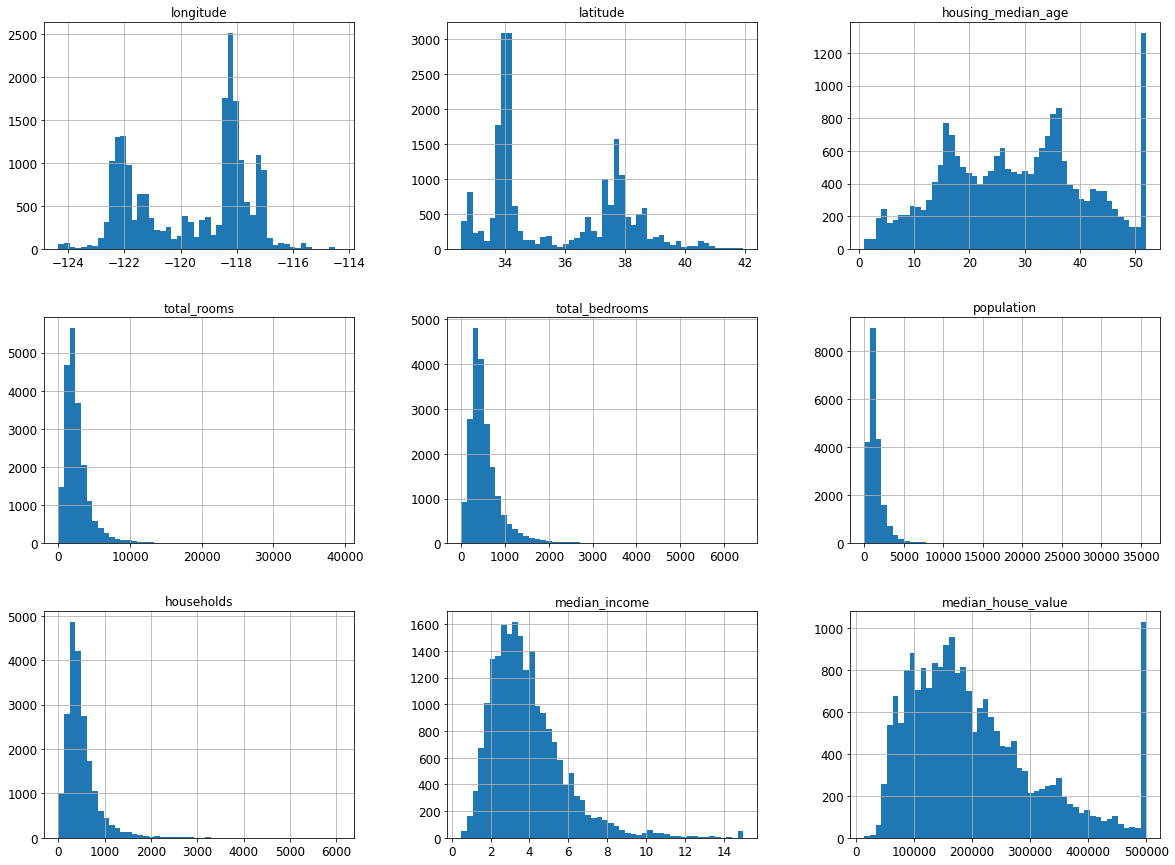

In [8]:
%matplotlib inline
#주피터 노트북 안에 그래프 표현
import matplotlib.pyplot as plt
housing.hist(bins=50, figsize=(20,15))
plt.show()

* 주요사항
1. median income 등의 몇몇 그래프 x축이 US달러 단위가 아니다. 실제로 10,000 : 1로 스케일을 축소시켰다. 전처리에서 다뤄주기
2. housing median age, median house value도 x축의 최솟값과 최댓값이 한정되어 있다.  
    해결책
    1. 한곗값 밖의 구역에 대한 정확한 레이블을 구한다.
    2. 훈련 세트에서 이런 구역을 제거한다.
3. 특성들의 스케일이 제각각이다.
4. 히스토그램이 오른쪽으로 더 멀리 뻗어있다.(꼬리가 두껍다.)  
    이 형태는 일부 머신러닌 알고리즘에서 패턴을 찾기 어려우므로 특성을 변형시켜준다.
    

### 2.3.4 테스트세트 만들기
데이터 스누핑 편향 : 훈련세트에 테스트세트를 포함하여 훈련시켰을 때, 이 세트로 일반화 오차를 추정하면 매우 낙관적인 추정이 되며, 새로운 데이터에 대해서 낮은 성능을 보임.

따라서 훈련시키기 전 테스트 세트를 따로 만들어야 함.

In [9]:
import numpy as np

def split_train_test(data, test_ratio):
    shuffled_indices = np.random.permutation(len(data))
    # np.random.shuffle은 array 자체를 shuffle, permutation은 np.arange(int)값을 shuffle
    test_set_size = int(len(data) * test_ratio)
    test_indices = shuffled_indices[:test_set_size]
    train_indices = shuffled_indices[test_set_size:]
    return data.iloc[train_indices], data.iloc[test_indices]
    # 섞어서 나눈 정수들을 index로 갖는 해당 데이터들로 train_set, test_set 생성

In [10]:
train_set, test_set= split_train_test(housing, 0.2)

In [11]:
print(train_set)

       longitude  latitude  housing_median_age  total_rooms  total_bedrooms  \
10686    -117.74     33.62                16.0       4134.0           740.0   
13863    -117.28     34.41                14.0       2105.0           396.0   
1276     -121.60     37.91                13.0       2479.0           394.0   
3397     -118.31     34.26                41.0       1297.0           327.0   
3620     -118.45     34.25                21.0       2143.0           565.0   
...          ...       ...                 ...          ...             ...   
9969     -122.48     38.51                49.0       1977.0           393.0   
17537    -121.89     37.35                47.0       2879.0           631.0   
3249     -119.99     36.09                23.0        333.0            92.0   
4219     -118.28     34.11                45.0       1607.0           331.0   
13031    -121.20     38.67                10.0       3875.0           668.0   

       population  households  median_income  media

In [12]:
print(test_set)

       longitude  latitude  housing_median_age  total_rooms  total_bedrooms  \
7254     -118.15     33.98                17.0       3361.0           925.0   
5059     -118.35     34.01                35.0       3776.0             NaN   
16840    -122.46     37.63                22.0       6728.0          1382.0   
6056     -117.80     34.03                25.0       4240.0           643.0   
529      -122.25     37.77                52.0        859.0           157.0   
...          ...       ...                 ...          ...             ...   
15785    -122.39     37.78                 3.0       3464.0          1179.0   
17855    -121.88     37.46                 5.0       1819.0           245.0   
6518     -118.01     34.07                24.0       5684.0          1485.0   
15013    -117.05     32.76                37.0       4879.0           906.0   
8802     -118.38     33.79                32.0      10445.0          1620.0   

       population  households  median_income  media

이 방법은 실행을 다시 할 때 마다 다른 테스트 세트가 생성된다.

해결책
1. 첫 실행에서 테스트 세트를 받아와 저장
2. 항상 같은 난수 인덱스가 생성되게 난수 발생기 초깃값 지정. ( ex) np.random.seed(42) )

데이터 세트를 업데이트 한 후에도 안정적인 훈련/ 테스트 분할을 위한 일반적인 해결책  
-> 샘플의 식별자를 사용해 테스트 세트로 보낼지 말지를 정한다.

In [13]:
from zlib import crc32

def test_set_check(identifier, test_ratio):
    return crc32(np.int64(identifier)) & 0xffffffff < test_ratio * 2**32

위 code 보충설명  
zlib : 데이터 압축할때 사용하는 모듈  
int64 : identifier를 64진수로 변환
crc32 : CRC32는 00000000 ~ FFFFFFFF 까지 2^32(약 43억)개의 경우의 수가 있다.  
& 0xffffffff : unsigned int로 변환하기 위한 부분. 파이썬2에서 crc32가 음수를 반환할 수도 있어 이 코드를 추가하여 양수값만 나오게 만들어준다.  
return값 설명 : 0 =< test_ratio =< 1이므로 0 ~ 2^32 사이의 정수로 표현할 수 있고, crc32값과의 비교를 통해 crc32값이 test_ratio보다 작은 경우 True를, 큰 경우 False를 반환


In [14]:
def split_train_test_by_id(data, test_ratio, id_column):
    ids = data[id_column] # data의 id_column이란 이름을 가진 column을 ids라고 정의.
    in_test_set = ids.apply(lambda id_: test_set_check(id_, test_ratio)) # 앞에서 만든 함수를 ids에 적용 -> T,F값 도출
    return data.loc[~in_test_set], data.loc[in_test_set]
    # [~a] : 조건을 충족하지 않는 데이터를 필터링 / [a] : 조건을 충족하는 데이터 필터링 

In [15]:
housing_with_id = housing.reset_index()
# .reset_index() : pandas의 함수 중 하나로, 데이터프레임의 기존 인덱스 값을 초기화하고 0부터 시작하는 새 인덱스가 데이터프레임에 추가됨.
train_set, test_set = split_train_test_by_id(housing_with_id, 0.2, "index")

In [16]:
print(housing.reset_index())
# reset_index()함수로 새 index컬럼이 데이터프레임 첫 column으로 추가됨

       index  longitude  latitude  housing_median_age  total_rooms  \
0          0    -122.23     37.88                41.0        880.0   
1          1    -122.22     37.86                21.0       7099.0   
2          2    -122.24     37.85                52.0       1467.0   
3          3    -122.25     37.85                52.0       1274.0   
4          4    -122.25     37.85                52.0       1627.0   
...      ...        ...       ...                 ...          ...   
20635  20635    -121.09     39.48                25.0       1665.0   
20636  20636    -121.21     39.49                18.0        697.0   
20637  20637    -121.22     39.43                17.0       2254.0   
20638  20638    -121.32     39.43                18.0       1860.0   
20639  20639    -121.24     39.37                16.0       2785.0   

       total_bedrooms  population  households  median_income  \
0               129.0       322.0       126.0         8.3252   
1              1106.0      2401

고유식별자를 만드는 다른 방법
위도와 경도같은 값을 이용해 ID로 만들 수 있다.

In [17]:
housing_with_id["id"] = housing["longitude"]*1000 + housing["latitude"]
train_set, test_set = split_train_test_by_id(housing_with_id, 0.2, "id")

In [18]:
print(housing_with_id)

       index  longitude  latitude  housing_median_age  total_rooms  \
0          0    -122.23     37.88                41.0        880.0   
1          1    -122.22     37.86                21.0       7099.0   
2          2    -122.24     37.85                52.0       1467.0   
3          3    -122.25     37.85                52.0       1274.0   
4          4    -122.25     37.85                52.0       1627.0   
...      ...        ...       ...                 ...          ...   
20635  20635    -121.09     39.48                25.0       1665.0   
20636  20636    -121.21     39.49                18.0        697.0   
20637  20637    -121.22     39.43                17.0       2254.0   
20638  20638    -121.32     39.43                18.0       1860.0   
20639  20639    -121.24     39.37                16.0       2785.0   

       total_bedrooms  population  households  median_income  \
0               129.0       322.0       126.0         8.3252   
1              1106.0      2401

사이킷런에서 데이터셋을 여러 세브셋으로 나누는 방법
* train_test_split (사이킷런 기본 제공 함수)
기본적인 split_train_set과 동일하나 아래 두 특징이 추가된다.  
random_state 매개변수 포함 : 난수 초깃값 지정  
행의 갯수가 같은 열 데이터셋을 넘겨서 같은 인덱스를 기반으로 나눌 수 있다.

In [19]:
from sklearn.model_selection import train_test_split

trian_set, test_set = train_test_split(housing, test_size=0.2, random_state=42)

계층적 샘플링(stratified sampling)  

무작위 샘플링은 데이터 전체를 대표하지 못하는 경우가 많다.  
샘플링 편향의 위험이 있어 전체 데이터를 계층이라는 동질의 그룹으로 나누고, 각 계층에서 올바른 수의 샘플을 추출한다.  
계층별로 충분한 데이터가 확보되어야 한다.

In [20]:
housing["income_cat"] = pd.cut(housing["median_income"],
bins=[0., 1.5, 3.0, 4.5, 6., np.inf], # np.inf : infinity값
labels=[1,2,3,4,5])

<AxesSubplot:>

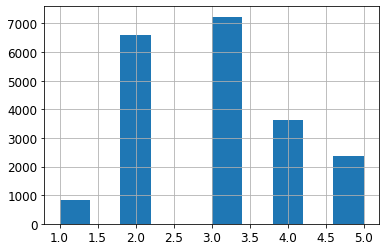

In [21]:
housing["income_cat"].hist()

In [22]:
from sklearn.model_selection import StratifiedShuffleSplit

split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split.split(housing, housing["income_cat"]):
    strat_train_set = housing.loc[train_index]
    strat_test_set = housing.loc[test_index]

* 위 code 설명  
n_splits : 몇 개의 세트로 나눌 것인지  
for문  : n_split이 1이므로 housing을 housing["income_cat"]에서 나눈 5개의 계층을 기준으로 나눈다.  
index를 받아와서 test set의 비율이 0.2인 데이터세트를 생성한다.

테스트 세트의 소득 카테고리 비율

In [23]:
strat_test_set["income_cat"].value_counts() / len(strat_test_set)

3    0.350533
2    0.318798
4    0.176357
5    0.114341
1    0.039971
Name: income_cat, dtype: float64

housing["income_cat"]은 계층적 샘플링을 위해 생성한 column이므로 삭제하여 원래 데이터로 만들어준다.

In [24]:
for set_ in (strat_train_set, strat_test_set):
    set_.drop("income_cat", axis=1, inplace=True)
    # axis=1 : column 선택, inplace=True면 따로 지정하지 않아도 변경 적용

## 2.4 데이터 이해를 위한 탐색과 시각화

In [25]:
housing = strat_train_set.copy()

### 2.4.1 지리적 데이터 시각화

<AxesSubplot:xlabel='longitude', ylabel='latitude'>

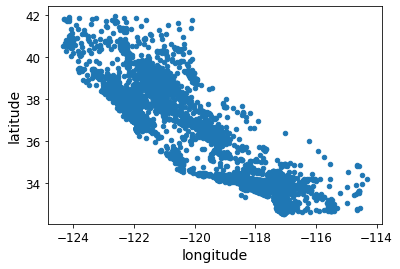

In [26]:
housing.plot(kind="scatter", x="longitude", y="latitude")

<AxesSubplot:xlabel='longitude', ylabel='latitude'>

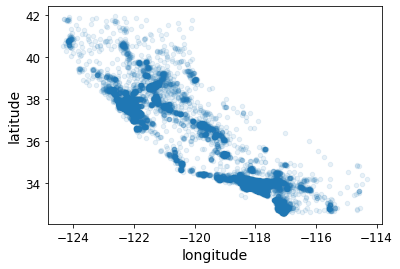

In [27]:
housing.plot(kind="scatter", x="longitude", y="latitude", alpha=0.1) # alpha : 투명도 조절

주택가격 나타내기

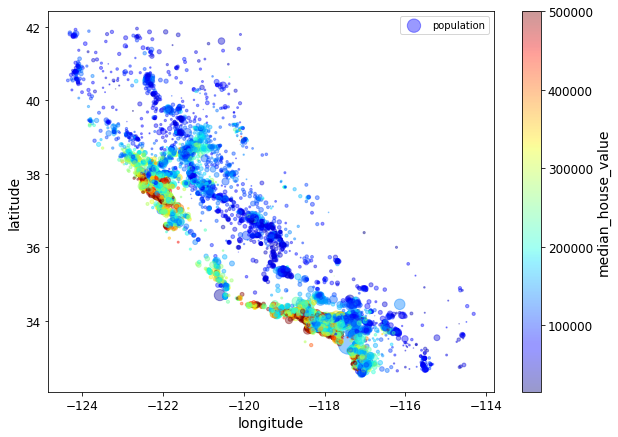

In [28]:
housing.plot(kind="scatter", x="longitude", y="latitude", alpha=0.4,
s=housing["population"]/100, label="population", figsize=(10,7),
c="median_house_value", cmap=plt.get_cmap("jet"), colorbar=True, sharex=False)
plt.legend()
# s: marker size
# c: marker color
# cmap: 컬러 맵 인스턴스. 여기선 jet 테마로 사용.
# colorbar : 오른쪽에 컬러바 생성
# sharex : subplot들의 x축을 공통으로 사용 -> True로 하면 추가된 subplot들의 x축이 나타나지 않은 채 출력됨.
# plt.legend() : 그래프에 범례 사용. plot의 label이 범례로 사용됨

### 2.4.2 상관관계 조사

데이터셋이 너무 크지 않기때문에 모든 특성간의 표준상관계수(standard correlation coefficient)를 계산한다.

In [29]:
corr_matrix = housing.corr()

In [30]:
print(corr_matrix["median_house_value"].sort_values(ascending=False)) # ascending=True는 오름차순, Flase는 내림차순

median_house_value    1.000000
median_income         0.687151
total_rooms           0.135140
housing_median_age    0.114146
households            0.064590
total_bedrooms        0.047781
population           -0.026882
longitude            -0.047466
latitude             -0.142673
Name: median_house_value, dtype: float64


* 1에 가까울수록 강한 양의 상관관계를 가진다.  
* -1에 가까울수록 강한 음의 상관관계를 가진다.  
* 0에 가깝다면 선형적인 상관관계가 없음을 뜻한다.  
* 비선형 관계에 대해서는 상관계수로 알 수 없다.

특성 사이의 상관관계를 확인하는 다른 방법
* 판다스 scatter_matrix 함수 사용

array([[<AxesSubplot:xlabel='median_house_value', ylabel='median_house_value'>,
        <AxesSubplot:xlabel='median_income', ylabel='median_house_value'>,
        <AxesSubplot:xlabel='total_rooms', ylabel='median_house_value'>,
        <AxesSubplot:xlabel='housing_median_age', ylabel='median_house_value'>],
       [<AxesSubplot:xlabel='median_house_value', ylabel='median_income'>,
        <AxesSubplot:xlabel='median_income', ylabel='median_income'>,
        <AxesSubplot:xlabel='total_rooms', ylabel='median_income'>,
        <AxesSubplot:xlabel='housing_median_age', ylabel='median_income'>],
       [<AxesSubplot:xlabel='median_house_value', ylabel='total_rooms'>,
        <AxesSubplot:xlabel='median_income', ylabel='total_rooms'>,
        <AxesSubplot:xlabel='total_rooms', ylabel='total_rooms'>,
        <AxesSubplot:xlabel='housing_median_age', ylabel='total_rooms'>],
       [<AxesSubplot:xlabel='median_house_value', ylabel='housing_median_age'>,
        <AxesSubplot:xlabel='median_incom

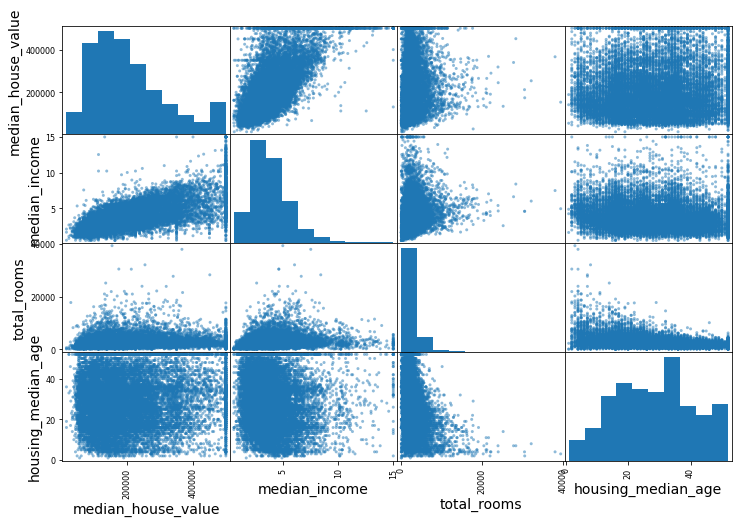

In [31]:
from pandas.plotting import scatter_matrix

attributes = ["median_house_value", "median_income", "total_rooms", "housing_median_age"]
scatter_matrix(housing[attributes], figsize=(12,8)) # attributes에 해당하는 columns에 대해서 상관관계 확인

<AxesSubplot:xlabel='median_income', ylabel='median_house_value'>

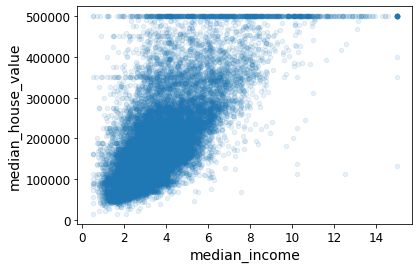

In [32]:
housing.plot(kind="scatter", x="median_income", y="median_house_value", alpha=0.1)

그래프 분석
* 상관관계가 매우 강하다.
* 가격 제한값이 $500,000에서 수평선으로 보인다.
* 중간중간 수평선 데이터들이 보인다. 알고리즘이 이상한 형태를 학습하지 않도록 제거하는 것이 좋다.


### 2.4.3 특성 조합으로 실험
가구당 방 개수, 가구당 인원 등 흥미로운 특성 조합을 생성하여 실험.

In [33]:
housing["rooms_per_household"] = housing["total_rooms"]/housing["households"]
housing["bedrooms_per_room"] = housing["total_bedrooms"]/housing["total_rooms"]
housing["population_per_household"] = housing["population"]/housing["households"]

In [34]:
corr_matrix = housing.corr()
corr_matrix["median_house_value"].sort_values(ascending=False)

median_house_value          1.000000
median_income               0.687151
rooms_per_household         0.146255
total_rooms                 0.135140
housing_median_age          0.114146
households                  0.064590
total_bedrooms              0.047781
population_per_household   -0.021991
population                 -0.026882
longitude                  -0.047466
latitude                   -0.142673
bedrooms_per_room          -0.259952
Name: median_house_value, dtype: float64

## 2.5 머신러닝 알고리즘을 위한 데이터 준비

데이터 준비 작업을 함수로 자동화해야 하는 이유
* 어떤 데이터셋에 대해서도 데이터 변환을 쉽게 반복할 수 있다.
* 향후 프로젝트에 사용할 수 있는 변환 라이브러리를 점진적으로 구축하게 된다.
* 실제 시스템에서 알고리즘에 새 데이터를 주입하기 전에 변환시키는데 이 함수를 사용할 수 있다.
* 여러가지 데이터 변환을 쉽게 시도해볼 수 있고, 어떤 조합이 가장 좋은지 확인하는데 편리하다.

In [35]:
housing = strat_train_set.drop("median_house_value", axis=1) # drop은 해당 부분에 대한 데이터 복사본을 생성.
housing_labels = strat_train_set["median_house_value"].copy()

### 2.5.1 데이터 정제
결측치 다루는 방법
* 해당 구역 제거
* 전체 특성 삭제
* 평균, 중간값 등의 값으로 채우기

In [36]:
# 옵션1 : housing.dropna(subset=["total_bedrooms"]) # NaN값을 삭제
# 옵션1 : housing.drop("total_bedrooms", axis=1)
# 옵션3 : median = housing["total_bedrooms"].median()
#        housing["total_bedrooms"].fillna(median, inplace=True) # NaN값을 median으로 대체

In [37]:
from sklearn.impute import SimpleImputer

imputer = SimpleImputer(strategy="median")

In [38]:
housing_num = housing.drop("ocean_proximity", axis=1) # ocean_proximity는 str이므로 중간값 계산 안되니 따로 복사본 만들어 빼주기

In [39]:
imputer.fit(housing_num)

SimpleImputer(strategy='median')

In [40]:
print(imputer.statistics_)

[-118.51      34.26      29.      2119.       433.      1164.
  408.         3.54155]


In [41]:
print(housing_num.median().values)

[-118.51      34.26      29.      2119.       433.      1164.
  408.         3.54155]


In [42]:
print(housing_num)

       longitude  latitude  housing_median_age  total_rooms  total_bedrooms  \
12655    -121.46     38.52                29.0       3873.0           797.0   
15502    -117.23     33.09                 7.0       5320.0           855.0   
2908     -119.04     35.37                44.0       1618.0           310.0   
14053    -117.13     32.75                24.0       1877.0           519.0   
20496    -118.70     34.28                27.0       3536.0           646.0   
...          ...       ...                 ...          ...             ...   
15174    -117.07     33.03                14.0       6665.0          1231.0   
12661    -121.42     38.51                15.0       7901.0          1422.0   
19263    -122.72     38.44                48.0        707.0           166.0   
19140    -122.70     38.31                14.0       3155.0           580.0   
19773    -122.14     39.97                27.0       1079.0           222.0   

       population  households  median_income  
1265

In [43]:
X = imputer.transform(housing_num) # housing_num의 결측치를 중간값으로 채워 X라 정의. numpy array형식임.

In [44]:
housing_tr = pd.DataFrame(X, columns=housing_num.columns, index=housing_num.index) # DataFrame형식으로 바꿔주기

In [45]:
print(housing_tr)

       longitude  latitude  housing_median_age  total_rooms  total_bedrooms  \
12655    -121.46     38.52                29.0       3873.0           797.0   
15502    -117.23     33.09                 7.0       5320.0           855.0   
2908     -119.04     35.37                44.0       1618.0           310.0   
14053    -117.13     32.75                24.0       1877.0           519.0   
20496    -118.70     34.28                27.0       3536.0           646.0   
...          ...       ...                 ...          ...             ...   
15174    -117.07     33.03                14.0       6665.0          1231.0   
12661    -121.42     38.51                15.0       7901.0          1422.0   
19263    -122.72     38.44                48.0        707.0           166.0   
19140    -122.70     38.31                14.0       3155.0           580.0   
19773    -122.14     39.97                27.0       1079.0           222.0   

       population  households  median_income  
1265

### 2.5.2 텍스트와 범주형 특성 다루기

In [46]:
housing_cat = housing[["ocean_proximity"]] # [[]]해주니까 column명이 나타나고, 열의 사이즈가 1로 표현됨. []일경우 열의 사이즈가 없다.
print(housing_cat.head(10))

      ocean_proximity
12655          INLAND
15502      NEAR OCEAN
2908           INLAND
14053      NEAR OCEAN
20496       <1H OCEAN
1481         NEAR BAY
18125       <1H OCEAN
5830        <1H OCEAN
17989       <1H OCEAN
4861        <1H OCEAN


대부분 머신러닝 알고리즘이 숫자를 다루므로 텍스트들을 숫자로 변환

In [47]:
from sklearn.preprocessing import OrdinalEncoder

ordinal_encoder = OrdinalEncoder()
housing_cat_encoded = ordinal_encoder.fit_transform(housing_cat)
print(housing_cat_encoded[:10])

[[1.]
 [4.]
 [1.]
 [4.]
 [0.]
 [3.]
 [0.]
 [0.]
 [0.]
 [0.]]


In [48]:
print(ordinal_encoder.categories_) # 카테고리 목록

[array(['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'],
      dtype=object)]


원-핫인코딩(one-hot encoding)  
앞의 방식으로 카테고리를 만들면 연속된 카테고리끼리 연관된 것으로 알고리즘이 인식한다.  
이 방법을 해결하기 위해 카테고리별 이진 특성을 이용하는데, 이를 원-핫인코딩이라고 부른다.

In [49]:
from sklearn.preprocessing import OneHotEncoder
cat_encoder = OneHotEncoder()
housing_cat_1hot = cat_encoder.fit_transform(housing_cat)
print(type(housing_cat_1hot))

<class 'scipy.sparse.csr.csr_matrix'>


원핫인코딩 결과 사이파이 희소행렬(SciPy Sparse matrix) 형식임.  
희소행렬은 0이 아닌 원소의 위치만 저장하기 때문에 수천 개의 카테고리가 있는 범주형 특성일 경우 효율적이다.  
toarray()를 사용하여 넘파이 배열로 변환할 수 있다.


In [50]:
housing_cat_1hot.toarray()

array([[0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0.],
       ...,
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0.]])

In [51]:
print(type(housing_cat_1hot.toarray()))

<class 'numpy.ndarray'>


In [52]:
print(cat_encoder.categories_) # 카테고리 목록

[array(['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'],
      dtype=object)]


### 2.5.3 나만의 변환기

In [53]:
from sklearn.base import BaseEstimator, TransformerMixin

rooms_ix, bedrooms_ix, population_ix, households_ix = 3,4,5,6 # column index

class CombinedAttributesAdder(BaseEstimator, TransformerMixin): # VaseEstimator, TransfromerMixin을 상속하는 class 생성
    def __init__(self, add_bedrooms_per_room = True): # 생성자 지정
        self.add_bedrooms_per_room = add_bedrooms_per_room
    def fit(self, X, y=None): # 훈련데이터 적용
        return self
    def transform(self, X):
        rooms_per_household = X[:, rooms_ix] / X[:, households_ix]
        population_per_household = X[:, population_ix] / X[:, households_ix]
        if self.add_bedrooms_per_room:
            bedrooms_per_room = X[:,bedrooms_ix] / X[:, rooms_ix]
            return np.c_[X, rooms_per_household, population_per_household, bedrooms_per_room]
        else:
            return np.c_[X, rooms_per_household, population_per_household]
        # numpy .c_ : 두 개의 1차원 배열을 칼럼으로 세로로 붙여서 2차원 배열 만들기
        
attr_adder = CombinedAttributesAdder(add_bedrooms_per_room=False) # attr_adder 객체 생성, False라서 밑에 transfrom 메서드에서 else에 해당하는 값이 return됨.
housing_extra_attribs = attr_adder.transform(housing.values) # transform 메서드 동작


### 2.5.4 특성 스케일링

가장 중요한 변환.  
머신러닝 알고리즘은 입력 숫자 특성의 스케일이 많이 다르면 잘 작동하지 않는다.  
모든 특성의 범위를 같도록 만들어주기위해 min-max scaling, standardization(표준화)가 널리 사용된다.
1. min-max scaling  
정규화(normalization)이라고도 함.  
0 ~ 1 범위에 들도록 데이터 값을 이동하여 스케일 조정.  
feature_range 매개변수로 범위를 변경할 수 있다.

2. 표준화(standardization)  
데이터 값에서 평균을 뺀 후 표준편차로 나누어 결과 분포의 분산이 1이 되도록 한다.  
범위의 상한과 하한이 없어 신경망 등에서 문제가 될 수 있다.  
정규화에 비해 이상치에 영향을 덜 받는다.  
사이킷런의 StandardScaler로 표준화 가능하다.

* 주의점  
스케일링 시 전체 데이터가 아닌 훈련 데이터에 대해서만 fit() 적용해야한다.

### 2.5.5 변환 파이프라인

In [54]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

num_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy="median")),  # (단계 이름, 변환기(fit, transform 메서드 갖고 있어야함)) # 중간값으로 결측치 채우기
    ('attribs_adder', CombinedAttributesAdder()),  # 특성조합 생성해서 해당 열 포함된 데이터세트 만들기 
    ('std_scaler', StandardScaler())  # 마지막 단계는 변환기, 추정기 모두 사용가능. # 정규화하여 scale 맞추기
])

housing_num_tr = num_pipeline.fit_transform(housing_num)

In [55]:
from sklearn.compose import ColumnTransformer

num_attribs = list(housing_num) # 수치형 열 이름 리스트
cat_attribs=["ocean_proximity"] # 범주형 열 이름 리스트

full_pipeline = ColumnTransformer([
    ("num", num_pipeline, num_attribs), # 이름, 변환기, 젹용될 열 이름 # 수치형 열들에 앞의 num_pipeline 적용
    ("cat", OneHotEncoder(), cat_attribs) # 범주형 열을 OneHotEncoder로 수치형으로 변환
])

housing_prepared = full_pipeline.fit_transform(housing)

In [59]:
housing_prepared

array([[-0.94135046,  1.34743822,  0.02756357, ...,  0.        ,
         0.        ,  0.        ],
       [ 1.17178212, -1.19243966, -1.72201763, ...,  0.        ,
         0.        ,  1.        ],
       [ 0.26758118, -0.1259716 ,  1.22045984, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [-1.5707942 ,  1.31001828,  1.53856552, ...,  0.        ,
         0.        ,  0.        ],
       [-1.56080303,  1.2492109 , -1.1653327 , ...,  0.        ,
         0.        ,  0.        ],
       [-1.28105026,  2.02567448, -0.13148926, ...,  0.        ,
         0.        ,  0.        ]])

In [60]:
housing_prepared.shape

(16512, 16)

희소 행렬과 밀집 행렬이 섞여있을 때, 밀집도가 임곗값보다 낮으면 희소 행렬을 반환한다.  
이 예에서는 밀집도가 임곗값보다 커서 밀집 행렬이 반환되었다.

## 2.6 모델 선택과 훈련

### 2.6.1 훈련 세트에서 훈련하고 평가하기

In [61]:
from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression()
lin_reg.fit(housing_prepared, housing_labels) # 선형 회귀로 훈련

LinearRegression()

In [62]:
some_data = housing.iloc[:5]
some_labels = housing_labels[:5]
some_data_prepared = full_pipeline.transform(some_data)
print("예측:", lin_reg.predict(some_data_prepared))
print("레이블:", list(some_labels))

예측: [ 85657.90192014 305492.60737488 152056.46122456 186095.70946094
 244550.67966089]
레이블: [72100.0, 279600.0, 82700.0, 112500.0, 238300.0]


RMSE 측정

In [63]:
from sklearn.metrics import mean_squared_error
housing_predictions = lin_reg.predict(housing_prepared)
lin_mse = mean_squared_error(housing_labels, housing_predictions)
lin_rmse = np.sqrt(lin_mse)
lin_rmse

68627.87390018745

예측오차가 너무 많이 벗어나 모델이 훈련 데이터에 과소적합되었음.  
해결책  
* 더 강력한 모델 선택
* 더 좋은 특성을 주입
* 모델의 규제를 감소

1. 더 복잡한 모델 선택

* 결정트리모델

In [64]:
from sklearn.tree import DecisionTreeRegressor

tree_reg = DecisionTreeRegressor()
tree_reg.fit(housing_prepared, housing_labels)

DecisionTreeRegressor()

In [65]:
housing_predictions = tree_reg.predict(housing_prepared)
tree_mse = mean_squared_error(housing_labels, housing_predictions)
tree_rmse = np.sqrt(tree_mse)
tree_rmse

0.0

DecisionTree Regressor는 모델이 심하게 과대적합된 것으로 보임.

### 2.6.2 교차 검증을 사용한 평가
k-fold cross validation(k-fold 교차검증)  
훈련세트를 폴드라고 불리는 서브셋으로 무작위 분할  
결정 트리 모델을 매번 다른 폴드를 선택해 평가하고 나머지 폴드는 훈련에 사용

In [66]:
from sklearn.model_selection import cross_val_score
scores = cross_val_score(tree_reg, housing_prepared, housing_labels, scoring="neg_mean_squared_error", cv=10)
# 모델, train set, train target, scoring방법(효용함수_클수록 좋다), 폴드 개수 
tree_rmse_scores = np.sqrt(-scores)
# 사이킷런에서 scoring이 음수로 되므로 root 계산 유효하게 - 붙임

In [67]:
def display_scores(scores):
    print("점수:", scores)
    print("평균:", scores.mean())
    print("표준편차:", scores.std())

In [69]:
display_scores(tree_rmse_scores)

점수: [70976.94704553 70901.03584101 66770.7463794  70485.17472495
 68694.1220063  77986.42892348 72935.95867114 72907.67927033
 69018.65482718 71452.42840641]
평균: 71212.91760957401
표준편차: 2887.1002106990622


In [70]:
lin_scores = cross_val_score(lin_reg, housing_prepared, housing_labels, scoring="neg_mean_squared_error", cv=10)
lin_rmse_scores = np.sqrt(-lin_scores)
display_scores(lin_rmse_scores)

점수: [71762.76364394 64114.99166359 67771.17124356 68635.19072082
 66846.14089488 72528.03725385 73997.08050233 68802.33629334
 66443.28836884 70139.79923956]
평균: 69104.07998247063
표준편차: 2880.3282098180675


결정트리 결과가 선형회귀 모델보다 나쁘게 나온다.

* random forest regression  
랜덤포레스트는 특성을 무작위로 선택해서 많은 결정 트리를 만들고 예측을 평균내는 방식으로 작동.  
여러 모델을 모아서 하나의 모델을 만드는 것을 앙상블 학습이라고 하며 머신러닝 알고리즘의 성능을 극대화하는 방법 중 하나.

In [71]:
from sklearn.ensemble import RandomForestRegressor

forest_reg = RandomForestRegressor()
forest_reg.fit(housing_prepared, housing_labels)

RandomForestRegressor()

In [73]:
housing_predictions = forest_reg.predict(housing_prepared)
forest_mse = mean_squared_error(housing_labels, housing_predictions)
forest_rmse = np.sqrt(forest_mse)
forest_rmse

18696.394078070163

In [74]:
from sklearn.model_selection import cross_val_score
scores = cross_val_score(forest_reg, housing_prepared, housing_labels, scoring="neg_mean_squared_error", cv=10)
forest_rmse_scores = np.sqrt(-scores)

In [75]:
display_scores(forest_rmse_scores)

점수: [51634.49212684 48982.85979409 46659.64153245 51812.57215747
 47400.94111439 51946.10624713 52592.43240883 49914.24610263
 48164.76644753 54011.66533304]
평균: 50311.97232644019
표준편차: 2321.816551367072


여전히 훈련 세트에 대한 점수가 검증 세트에 대한 점수보다 훨씬 낮으므로 여전히 훈련 세트에 과대적합되어 있다.
해결책
* 모델을 간단히 하기 _ 가능성 있는 2~5개의 모델을 선정
* 규제
* 더 많은 훈련 데이터 모으기

In [77]:
# 실험한 모델 저장하고 복원하기

#import joblib

#joblib.dump(my_model, "mymodel.pkl")
#my_model_loaded = joblib.load("mymodel.pkl")

## 2.7 모델 세부 튜닝
### 2.7.1 그리드 탐색
하이퍼파라미터 조정

In [79]:
from sklearn.model_selection import GridSearchCV

param_grid = [
    {'n_estimators': [3, 10, 30], 'max_features': [2, 4, 6, 8]}, # 3*4=12
    {'bootstrap': [False], 'n_estimators': [3, 10], 'max_features': [2,3,4]} # 2*3=6
] # 하이퍼파라미터 7장 설명, 총 18개의 조합을 탐색

forest_reg = RandomForestRegressor()
grid_search = GridSearchCV(forest_reg, param_grid, cv=5, scoring='neg_mean_squared_error', return_train_score=True) # 폴드가 5이므로 5번 훈련
# 전체 18*5=90번 훈련.
grid_search.fit(housing_prepared, housing_labels)

GridSearchCV(cv=5, estimator=RandomForestRegressor(),
             param_grid=[{'max_features': [2, 4, 6, 8],
                          'n_estimators': [3, 10, 30]},
                         {'bootstrap': [False], 'max_features': [2, 3, 4],
                          'n_estimators': [3, 10]}],
             return_train_score=True, scoring='neg_mean_squared_error')

In [80]:
grid_search.best_params_ # 최적 파라미터

{'max_features': 8, 'n_estimators': 30}

In [81]:
grid_search.best_estimator_ # 최적 추정기

RandomForestRegressor(max_features=8, n_estimators=30)

In [82]:
# 평가점수
cvres = grid_search.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]): # zip : 길이가 같은 데이터 묶어서 가져오는 내장함수
    print(np.sqrt(-mean_score), params)

63527.704484173 {'max_features': 2, 'n_estimators': 3}
55830.963797483084 {'max_features': 2, 'n_estimators': 10}
52466.71359721598 {'max_features': 2, 'n_estimators': 30}
59230.888598358135 {'max_features': 4, 'n_estimators': 3}
52814.55387024775 {'max_features': 4, 'n_estimators': 10}
50467.35714641801 {'max_features': 4, 'n_estimators': 30}
59452.50956300892 {'max_features': 6, 'n_estimators': 3}
52311.896269079916 {'max_features': 6, 'n_estimators': 10}
50264.20020107844 {'max_features': 6, 'n_estimators': 30}
59106.51430080662 {'max_features': 8, 'n_estimators': 3}
52121.88907270532 {'max_features': 8, 'n_estimators': 10}
50012.431401167145 {'max_features': 8, 'n_estimators': 30}
62270.174597557874 {'bootstrap': False, 'max_features': 2, 'n_estimators': 3}
54332.1001460654 {'bootstrap': False, 'max_features': 2, 'n_estimators': 10}
59949.27024346906 {'bootstrap': False, 'max_features': 3, 'n_estimators': 3}
52753.255612941124 {'bootstrap': False, 'max_features': 3, 'n_estimators':

### 2.7.2 랜덤 탐색
하이퍼파라미터 탐색 공간이 커질때 사용

각 반복마다 하이퍼파라미터에 임의의 수를 대입하여 지정한 횟수만큼 평가  
장점  
* 랜덤 탐색을 1,000회 반복하도록 실행하면 하이퍼파라미터마다 각기 다른 1,000개의 값을 탐색
* 단순히 반복 횟수를 조절하는 것만으로 하이퍼파라미터 탐색에 투입할 컴퓨팅 자원을 제어할 수 있다.

### 2.7.3 앙상블 방법
모델의 그룹이 최상의 단일 모델보다 더 나은 성능을 발휘할 경우가 많다.

### 2.7.4 최상의 모델과 오차 분석


In [87]:
# 각 특성들의 상대적인 중요도
feature_importances = grid_search.best_estimator_.feature_importances_
feature_importances

array([6.59066578e-02, 6.30629920e-02, 4.58726968e-02, 1.53112460e-02,
       1.52527916e-02, 1.56376496e-02, 1.40983496e-02, 3.71940753e-01,
       4.91648825e-02, 1.15154347e-01, 6.82854002e-02, 7.66348322e-03,
       1.47361062e-01, 1.00804784e-04, 1.92778933e-03, 3.25909438e-03])

In [88]:
extra_attribs = ["room_per_hhold", "pop_per_hhold", "bedrooms_per_room"]
cat_encoder = full_pipeline.named_transformers_["cat"] # full_pipeline의 cat이라고 이름붙였던 범주형 열을 onehotencoder로 변환
cat_one_hot_attribs = list(cat_encoder.categories_[0]) # 카테고리 목록
attributes = num_attribs + extra_attribs + cat_one_hot_attribs # 특성 전체 목록
sorted(zip(feature_importances, attributes), reverse=True) # 내림차순 정렬

[(0.37194075335527466, 'median_income'),
 (0.14736106164221763, 'INLAND'),
 (0.11515434708254584, 'pop_per_hhold'),
 (0.06828540018727261, 'bedrooms_per_room'),
 (0.06590665779907959, 'longitude'),
 (0.06306299202476136, 'latitude'),
 (0.04916488245930817, 'room_per_hhold'),
 (0.04587269680995018, 'housing_median_age'),
 (0.015637649596628975, 'population'),
 (0.015311246044404547, 'total_rooms'),
 (0.015252791642315926, 'total_bedrooms'),
 (0.014098349642164498, 'households'),
 (0.007663483223068626, '<1H OCEAN'),
 (0.0032590943803832927, 'NEAR OCEAN'),
 (0.001927789326534069, 'NEAR BAY'),
 (0.00010080478408996869, 'ISLAND')]

이 정보를 바탕으로 덜 중요한 특성을 제외할 수 있다.

### 2.7.5 테스트 세트로 시스템 평가하기

In [96]:
final_model = grid_search.best_estimator_

X_test = strat_test_set.drop("median_house_value", axis=1)
y_test = strat_test_set["median_house_value"].copy()

X_test_prepared = full_pipeline.transform(X_test)

final_predictions = final_model.predict(X_test_prepared)

final_mse = mean_squared_error(y_test, final_predictions)
final_rmse = np.sqrt(final_mse)

In [97]:
final_rmse

48305.21267918537

일반화 오차의 95% 신뢰구간 계산

In [98]:
from scipy import stats
confidence = 0.95
squared_errors = (final_predictions - y_test) **2
np.sqrt(stats.t.interval(confidence, len(squared_errors)-1,
loc=squared_errors.mean(),
scale=stats.sem(squared_errors))) # 신뢰계수, 자유도, 표본평균, 표준오차 

array([46284.90995041, 50244.34550121])